## 📦 SSD MobileNetV2 FPNLite 320x320

This model is a lightweight object detector from TensorFlow Hub:
**[`ssd_mobilenet_v2/fpnlite_320x320`](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1)**

### 🔍 Model Details
- **Architecture**: SSD with MobileNetV2 backbone and FPNLite feature extractor
- **Input Size**: 320x320
- **Output**: Bounding boxes, class labels (COCO), and scores
- **Optimized For**: Real-time detection on mobile/edge devices

Great for fast, real-time applications with moderate accuracy.


# Imports Section

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
# Load the model
model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

### 🛠️ Helper Function: Load and Preprocess Image

This function loads an image from a given URL and preprocesses it to match the input size required by the MobileNet model (typically 320x320 or 224x224, depending on the version used).


In [ ]:
# Function to load and preprocess the image from a URL
def load_and_preprocess_image_from_url(image_url):
    # Fetch the image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Convert image to numpy array
    image_np = np.array(img)

    # Resize image to the required size for the model (320x320)
    image_resized = cv2.resize(image_np, (320, 320))

    # Normalize image
    image_norm = np.array(image_resized, dtype=np.uint8)  # uint8 format for TensorFlow

    # Add batch dimension
    image_expanded = np.expand_dims(image_norm, axis=0)

    return image_expanded, image_np


Number of detections above threshold: 8


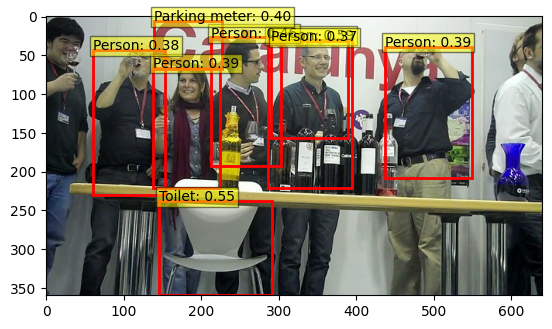

In [ ]:

# URL of the image (replace with your own URL)
image_url = 'https://farm3.staticflickr.com/2765/4464790131_d5bf3296b6_z.jpg'  # Replace with your image URL

# Load and preprocess the image from the URL
image_expanded, image_np = load_and_preprocess_image_from_url(image_url)

# Run inference
result = run_inference(image_expanded)

# Visualize the results
visualize_results(image_np, result,0.35)

### 🚀 Inference Function: Run Model on Image

This function takes a preprocessed image and performs inference using the loaded SSD MobileNet model.  
It returns the model's output as a dictionary of NumPy arrays containing detection boxes, class labels, scores, and the number of detections.

In [ ]:
# Perform inference on the image
def run_inference(image_expanded):
    # Run the image through the model
    results = model(image_expanded)

    # Extract relevant data from the results
    result = {key:value.numpy() for key,value in results.items()}

    return result

### 🖼️ Visualization Function: Display Detection Results

This function visualizes the output of the SSD MobileNet model by drawing bounding boxes and labels on the image.

- Filters detections using a confidence `threshold` (default = 0.5)
- Converts normalized bounding boxes to image coordinates
- Displays class labels using COCO dataset categories
- Draws labeled boxes on the image using `matplotlib`

Also prints the number of detections that exceed the confidence threshold.

In [ ]:
# Function to visualize the results with a minimum threshold for detection confidence
def visualize_results(image_np, result, threshold=0.5):
    # Extract detected bounding boxes, class labels, and scores
    boxes = result['detection_boxes']
    class_ids = result['detection_classes'].astype(int)  # Corrected key for class IDs
    scores = result['detection_scores']

    # Load COCO class labels (you can also define this as a list of class names)
    class_labels = [
        'Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane', 'Bus', 'Train', 'Truck', 'Boat', 'Traffic light',
        'Fire hydrant', 'Stop sign', 'Parking meter', 'Bench', 'Bird', 'Cat', 'Dog', 'Horse', 'Sheep', 'Cow',
        'Elephant', 'Bear', 'Zebra', 'Giraffe', 'Backpack', 'Umbrella', 'Handbag', 'Tie', 'Suitcase', 'Frisbee',
        'Skis', 'Snowboard', 'Sports ball', 'Kite', 'Baseball bat', 'Baseball glove', 'Skateboard', 'Surfboard',
        'Tennis racket', 'Bottle', 'Wine glass', 'Cup', 'Fork', 'Knife', 'Spoon', 'Bowl', 'Banana', 'Apple',
        'Sandwich', 'Orange', 'Broccoli', 'Carrot', 'Hot dog', 'Pizza', 'Donut', 'Cake', 'Chair', 'Couch',
        'Potted plant', 'Bed', 'Dining table', 'Toilet', 'Laptop', 'Mouse', 'Remote', 'Keyboard', 'Cell phone',
        'Microwave', 'Oven', 'Toaster', 'Sink', 'Refrigerator', 'Book', 'Clock', 'Vase', 'Scissors', 'Teddy bear',
        'Hair drier', 'Toothbrush'
    ]

    # Visualize the detections
    plt.imshow(image_np)
    ax = plt.gca()

    # Counter for detections above threshold
    detections_above_threshold = 0

    # Iterate through all detections
    for i in range(len(boxes[0])):
        score = scores[0][i]  # Extract the individual score
        if score > threshold:
            detections_above_threshold += 1  # Increment the counter for detections above threshold

            # Get bounding box coordinates
            ymin, xmin, ymax, xmax = boxes[0][i]

            # Convert to image coordinates
            (xmin, ymin, xmax, ymax) = (xmin * image_np.shape[1], ymin * image_np.shape[0], xmax * image_np.shape[1], ymax * image_np.shape[0])

            # Ensure class_id is within the valid range of class_labels
            class_id = class_ids[0][i] - 1  # TensorFlow class IDs start from 1
            if class_id >= len(class_labels):  # If class_id exceeds class_labels list, set to "Unknown"
                label = "Unknown"
            else:
                label = class_labels[class_id]

            # Draw the bounding box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'))

            # Add class label and score
            ax.text(xmin, ymin, f'{label}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 2})

    # Print the number of detections above the threshold
    print(f"Number of detections above threshold: {detections_above_threshold}")

    plt.show()

### 💾 Save SSD MobileNet Model as TensorFlow Lite (TFLite)

This script performs the following steps:

1. **Mounts Google Drive** to allow saving the converted model.
2. **Converts the TensorFlow Hub model** (`ssd_mobilenet_v2/fpnlite_320x320`) to TensorFlow Lite format using `TFLiteConverter`.
3. **Creates a directory** in Google Drive (if it doesn’t exist) to store the model.
4. **Saves the TFLite model** as `model.tflite` in the specified path.

Useful for deploying object detection models on mobile or embedded devices with TensorFlow Lite.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from google.colab import drive

# Mount Google Drive to save the model
drive.mount('/content/drive')


# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([model.signatures['serving_default']])
tflite_model = converter.convert()

# Define the path where you want to save the model in Google Drive
save_path = '/content/drive/MyDrive/saved_models/mobilenetssd'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Directory created: {save_path}")

# Save the TFLite model to the specified path in Google Drive
model_file_path = os.path.join(save_path, 'model.tflite')
with open(model_file_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to: {model_file_path}")


Mounted at /content/drive
Directory created: /content/drive/MyDrive/saved_models/mobilenetssd
TensorFlow Lite model saved to: /content/drive/MyDrive/saved_models/mobilenetssd/model.tflite
